In [67]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import chi2, mutual_info_classif

from collections import Counter

from sklearn.model_selection import train_test_split , cross_val_score , StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score , mean_squared_error , confusion_matrix , precision_score , recall_score, classification_report, RocCurveDisplay,f1_score,mean_absolute_percentage_error,precision_recall_curve,fbeta_score
from sklearn.metrics._scorer import _SCORERS,make_scorer

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier , GradientBoostingClassifier , RandomForestRegressor , RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso,Ridge

from xgboost import XGBClassifier,DMatrix
import shap
from sklearn.inspection import PartialDependenceDisplay as PD
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler,OneHotEncoder,KBinsDiscretizer,PolynomialFeatures,LabelEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.experimental import enable_iterative_imputer

import warnings 
warnings.filterwarnings("ignore")

# 1. Business Overview

### Business Background
---
In the competitive e-commerce industry, retaining customers is crucial for long-term success, as customer churn leads to lost revenue and higher acquisition costs. Our company faces the challenge of stabilizing customer base in the middle of intense competition. By utilizing data analytics and machine learning, we aim to identify at-risk customers and implement targeted retention strategies or optimizing resources alocation.


### Data details
---
Features
-	Tenure: Tenure of a customer in the company.
-	WarehouseToHome: Distance between the warehouse to the customer’s home.
-	NumberOfDeviceRegistered: Total number of deceives is registered on a particular customer.
-	PreferedOrderCat: Preferred order category of a customer in the last month.
-	SatisfactionScore: Satisfactory score of a customer on service.
-	MaritalStatus: Marital status of a customer.
-	NumberOfAddress: Total number of added on a particular customer.
-	Complaint: Any complaint has been raised in the last month.
-	DaySinceLastOrder: Day since last order by customer.
-	CashbackAmount: Average cashback in last month
-	Churn: Churn flag.


### Business Problem
---
Customer churn, the phenomenon where customers stop using a company's products or services, poses a significant risk as it leads to lost revenue and lost any retention efforts. Understanding and predicting churn is crucial for our company to implement effective retention strategies. This involves examining various customer-related features such as tenure, satisfaction scores, complains, cashback amount, etc to understand their impact on churn.

### Machine Learning Objective 
--- 
The objective are as followed : 

- Develop a machine learning model to accurately predict customer churn within the next month, enabling the company to implement targeted retention strategies and reduce churn

- Cost Reduction through predictive analysis by Eliminating Cashback for Predicted Churners

In [68]:
df = pd.read_csv("data_ecommerce_customer_churn.csv")
df

Tenure  WarehouseToHome  NumberOfDeviceRegistered    PreferedOrderCat  \
0       15.0             29.0                         4  Laptop & Accessory   
1        7.0             25.0                         4              Mobile   
2       27.0             13.0                         3  Laptop & Accessory   
3       20.0             25.0                         4             Fashion   
4       30.0             15.0                         4              Others   
...      ...              ...                       ...                 ...   
3936    28.0              9.0                         5             Fashion   
3937     8.0              7.0                         2        Mobile Phone   
3938    30.0              6.0                         5  Laptop & Accessory   
3939     6.0              NaN                         4              Mobile   
3940     2.0              7.0                         3  Laptop & Accessory   

      SatisfactionScore MaritalStatus  NumberOfAddress  Complain  \
0                     3        Single                2         0   
1                     1       Married                2         0   
2                     1       Married                5         0   
3                     3      Divorced                7         0   
4                     4        Single                8         0   
...                 ...           ...              ...       ...   
3936                  3       Married                8         0   
3937                  2        Single                4         0   
3938                  3       Married                3         1   
3939                  3       Married               10         1   
3940                  5       Married                1         0   

      DaySinceLastOrder  CashbackAmount  Churn  
0                   7.0          143.32      0  
1                   7.0          129.29      0  
2                   7.0          168.54      0  
3                   NaN          230.27      0  
4                   8.0          322.17      0  
...                 ...             ...    ...  
3936                1.0          231.86      0  
3937                4.0          157.80      0  
3938                2.0          156.60      0  
3939                0.0          124.37      1  
3940                2.0          153.73      0  

[3941 rows x 11 columns]

# 2. Exploratory Data Analysis

In [69]:
data=[]
for i in df.columns:
    data.append([i,
                 df[i].dtypes,
                 df[i].isna().sum(),
                 df[i].nunique(),
                 df[i].unique()])
    
dataset = pd.DataFrame(data,columns=["feature name","type","null","nunique","unique"])
dataset

feature name     type  null  nunique  \
0                     Tenure  float64   194       36   
1            WarehouseToHome  float64   169       33   
2   NumberOfDeviceRegistered    int64     0        6   
3           PreferedOrderCat   object     0        6   
4          SatisfactionScore    int64     0        5   
5              MaritalStatus   object     0        3   
6            NumberOfAddress    int64     0       14   
7                   Complain    int64     0        2   
8          DaySinceLastOrder  float64   213       22   
9             CashbackAmount  float64     0     2335   
10                     Churn    int64     0        2   

                                               unique  
0   [15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,...  
1   [29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0...  
2                                  [4, 3, 6, 2, 5, 1]  
3   [Laptop & Accessory, Mobile, Fashion, Others, ...  
4                                     [3, 1, 4, 2, 5]  
5                         [Single, Married, Divorced]  
6     [2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]  
7                                              [0, 1]  
8   [7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,...  
9   [143.32, 129.29, 168.54, 230.27, 322.17, 152.8...  
10                                             [0, 1]

In [70]:
categorical = ["PreferedOrderCat","SatisfactionScore","MaritalStatus","Complain"]
numerical = ["Tenure","WarehouseToHome","NumberOfDeviceRegistered","NumberOfAddress","DaySinceLastOrder","CashbackAmount"]

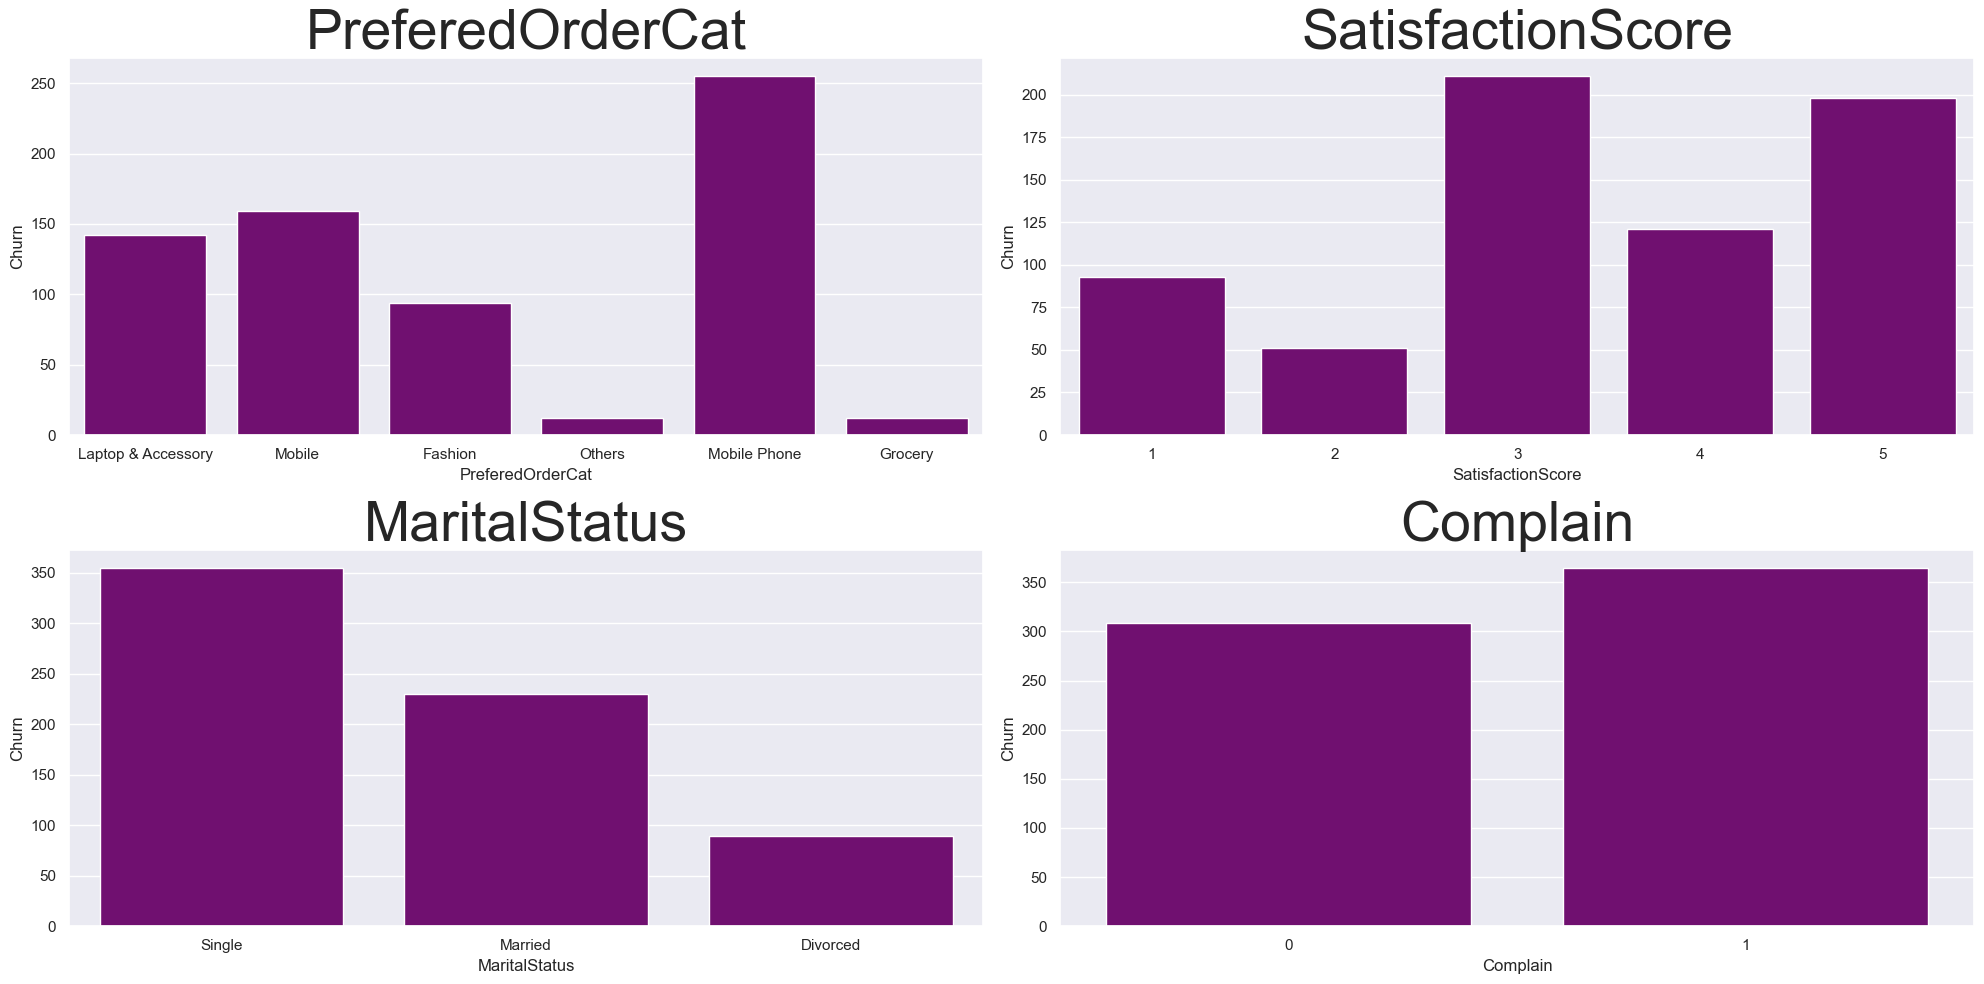

In [71]:
plt.figure(figsize=(20,10))
sns.set(palette="Set1")
plotnumber=1

for feature in categorical :
    ax = plt.subplot(2,2,plotnumber)
    sns.barplot(df,x=feature,y="Churn",estimator=np.sum,errorbar=None,color="purple")
    plt.title(feature,fontsize=40)
    plotnumber+=1
    plt.tight_layout()

## The graphs above represents all churned customers based on their categories
---

PreferredOrderCat
* People who churned the most preferred mobile phone

SatisfactionScore
* People who churned the most are somewhat satisfied (3) with the supermarket

MaritalStatus 
* People who churned the most are single

Complain
* People who churned the most have voiced their complains

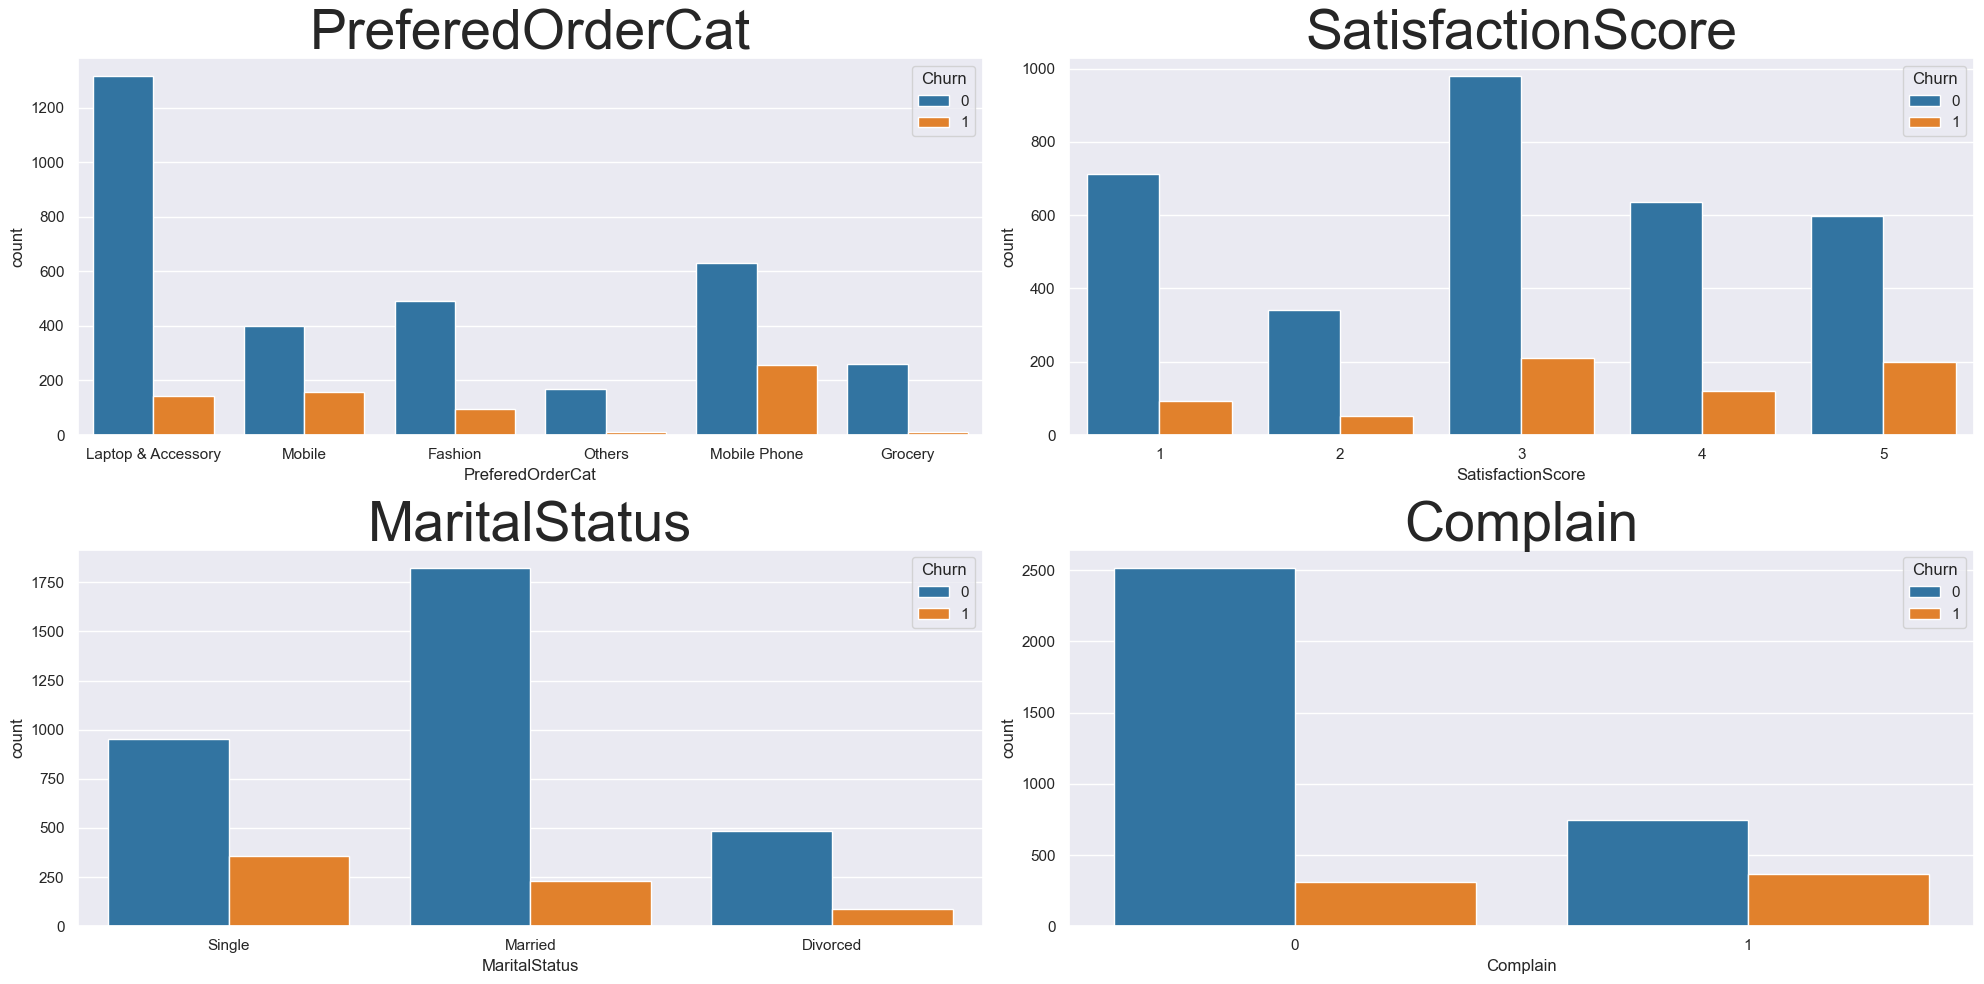

In [72]:
plt.figure(figsize=(20,10))
sns.set(palette="tab10")
plotnumber=1

for feature in categorical :
    ax = plt.subplot(2,2,plotnumber)
    sns.countplot(df,x=feature,hue="Churn")
    plt.title(feature,fontsize=40)
    plotnumber+=1
    plt.tight_layout()

## The graphs above represents the comparison between churned customers and customers who did not churn based on their categories
---

PreferedOrderCat
* Most people who churned preferred mobile phones
* People who buys groceries from the e-commerce did not churn as much

SatisfactionScore
* most people in both groups were somewhat satisfied (3) with the supermarket

MaritalStatus
* most people who churned were single
* most people who did not churn were married

Complain
* people who complained churned more than people who did not complain
* Most people who did not churn did not voice their complain


In [73]:
complain = pd.DataFrame({"Churned, no complains":[100-(len(df[(df["Complain"]==0)&(df["Churn"]==0)])/len(df[(df["Complain"]==0)])*100)],
                         "Churned, with complains":[100-(len(df[(df["Complain"]==1)&(df["Churn"]==0)])/len(df[(df["Complain"]==1)])*100)]})
complain

Churned, no complains  Churned, with complains
0               10.92645                 32.79425

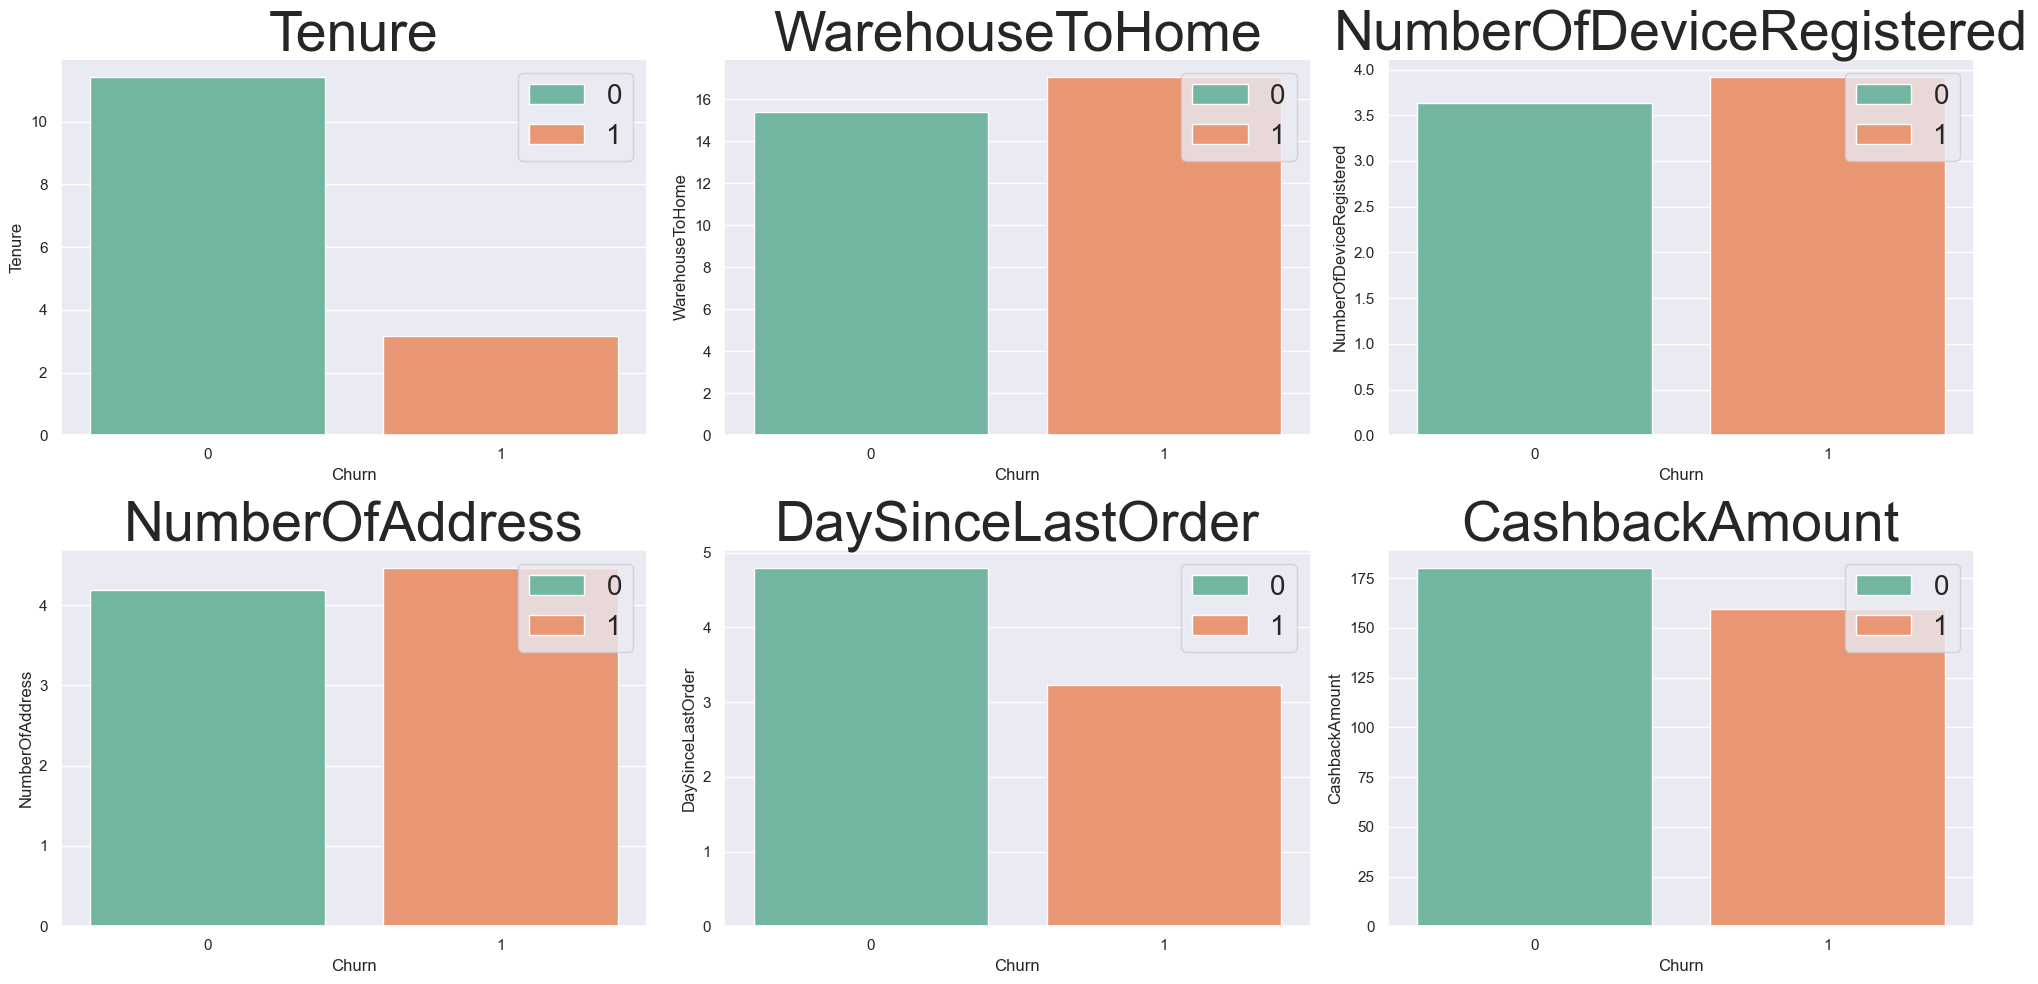

In [74]:
plt.figure(figsize=(20,10))
sns.set(palette="Set2")
plotnumber=1

for feature in numerical :
    ax = plt.subplot(2,3,plotnumber)
    sns.barplot(df,x="Churn",y=feature,hue="Churn",errorbar=None)
    plt.title(feature,fontsize=40)
    plt.legend(fontsize=20)
    plotnumber+=1
    plt.tight_layout()

In [75]:
df.groupby("Churn")[numerical].agg("mean")

Tenure  WarehouseToHome  NumberOfDeviceRegistered  NumberOfAddress  \
Churn                                                                          
0      11.427160        15.376187                  3.629324         4.191001   
1       3.160656        17.061889                  3.921365         4.464392   

       DaySinceLastOrder  CashbackAmount  
Churn                                     
0               4.797996      180.286847  
1               3.231861      159.357285

## The graphs and the table above represents customers who churned and did not churn based on their numerical values 

---

Tenure
* People who churned have much less average Tenure (3.1) compared to those who did not (11.4)

WarehouseToHome
* Both not churned group and churned group have similar distance warehouse to home (15.3 to 17.0)

NumberOfDeviceRegistered
* Both not churned group and churned group have similar number of registered device (3.6 to 3.9)

NumberOfAddress
* Both not churned group and churned group have similar number of registered address (4.2 to 4.5)

DaySinceLastOrder
* People who churned have less days since last order (3.3) compared to people who did not (4.8)

CashbackAmount
* People who churned received less cashbackk (159) compared to people who did not (180.3)

# 3. Data Cleaning

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3941 entries, 0 to 3940
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Tenure                    3747 non-null   float64
 1   WarehouseToHome           3772 non-null   float64
 2   NumberOfDeviceRegistered  3941 non-null   int64  
 3   PreferedOrderCat          3941 non-null   object 
 4   SatisfactionScore         3941 non-null   int64  
 5   MaritalStatus             3941 non-null   object 
 6   NumberOfAddress           3941 non-null   int64  
 7   Complain                  3941 non-null   int64  
 8   DaySinceLastOrder         3728 non-null   float64
 9   CashbackAmount            3941 non-null   float64
 10  Churn                     3941 non-null   int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 338.8+ KB


In [77]:
data=[]
for i in df.columns:
    data.append([i,
                 df[i].dtypes,
                 df[i].isna().sum(),
                 df[i].nunique(),
                 df[i].unique()])
    
dataset = pd.DataFrame(data,columns=["feature name","type","null","nunique","unique"])
dataset

feature name     type  null  nunique  \
0                     Tenure  float64   194       36   
1            WarehouseToHome  float64   169       33   
2   NumberOfDeviceRegistered    int64     0        6   
3           PreferedOrderCat   object     0        6   
4          SatisfactionScore    int64     0        5   
5              MaritalStatus   object     0        3   
6            NumberOfAddress    int64     0       14   
7                   Complain    int64     0        2   
8          DaySinceLastOrder  float64   213       22   
9             CashbackAmount  float64     0     2335   
10                     Churn    int64     0        2   

                                               unique  
0   [15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,...  
1   [29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0...  
2                                  [4, 3, 6, 2, 5, 1]  
3   [Laptop & Accessory, Mobile, Fashion, Others, ...  
4                                     [3, 1, 4, 2, 5]  
5                         [Single, Married, Divorced]  
6     [2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]  
7                                              [0, 1]  
8   [7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,...  
9   [143.32, 129.29, 168.54, 230.27, 322.17, 152.8...  
10                                             [0, 1]

Text(0.5, 1.0, 'CashbackAmount')

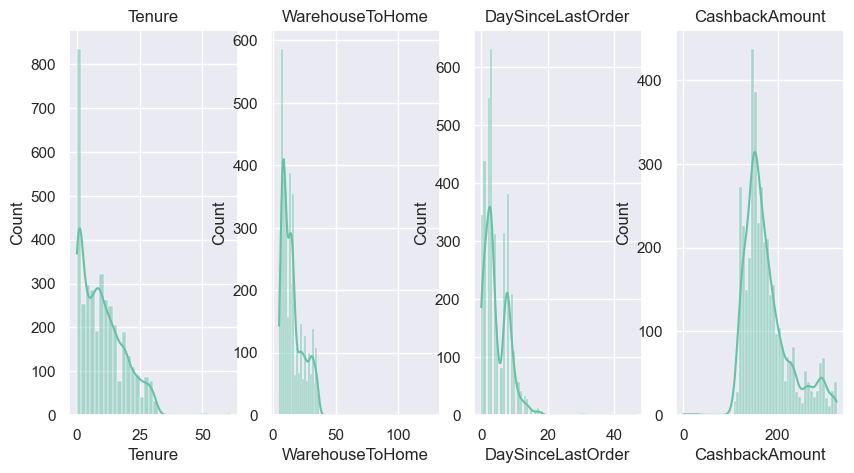

In [78]:
fig,ax = plt.subplots(1,4,figsize=(10,5))
sns.histplot(df["Tenure"],ax=ax[0],kde=True)
ax[0].set_title("Tenure")
sns.histplot(df["WarehouseToHome"],ax=ax[1],kde=True)
ax[1].set_title("WarehouseToHome")
sns.histplot(df["DaySinceLastOrder"],ax=ax[2],kde=True)
ax[2].set_title("DaySinceLastOrder")
sns.histplot(df["CashbackAmount"],ax=ax[3],kde=True)
ax[3].set_title("CashbackAmount")

The data are not normaly distributed, so the null values will be filled with median

---

In [79]:
df = df.drop_duplicates()

In [80]:
df["Tenure"].fillna(df["Tenure"].describe()["50%"],inplace=True)
df["WarehouseToHome"].fillna(df["WarehouseToHome"].describe()["50%"],inplace=True)
df["DaySinceLastOrder"].fillna(df["DaySinceLastOrder"].describe()["50%"],inplace=True)
df["CashbackAmount"].fillna(df["CashbackAmount"].describe()["50%"],inplace=True)

<Axes: >

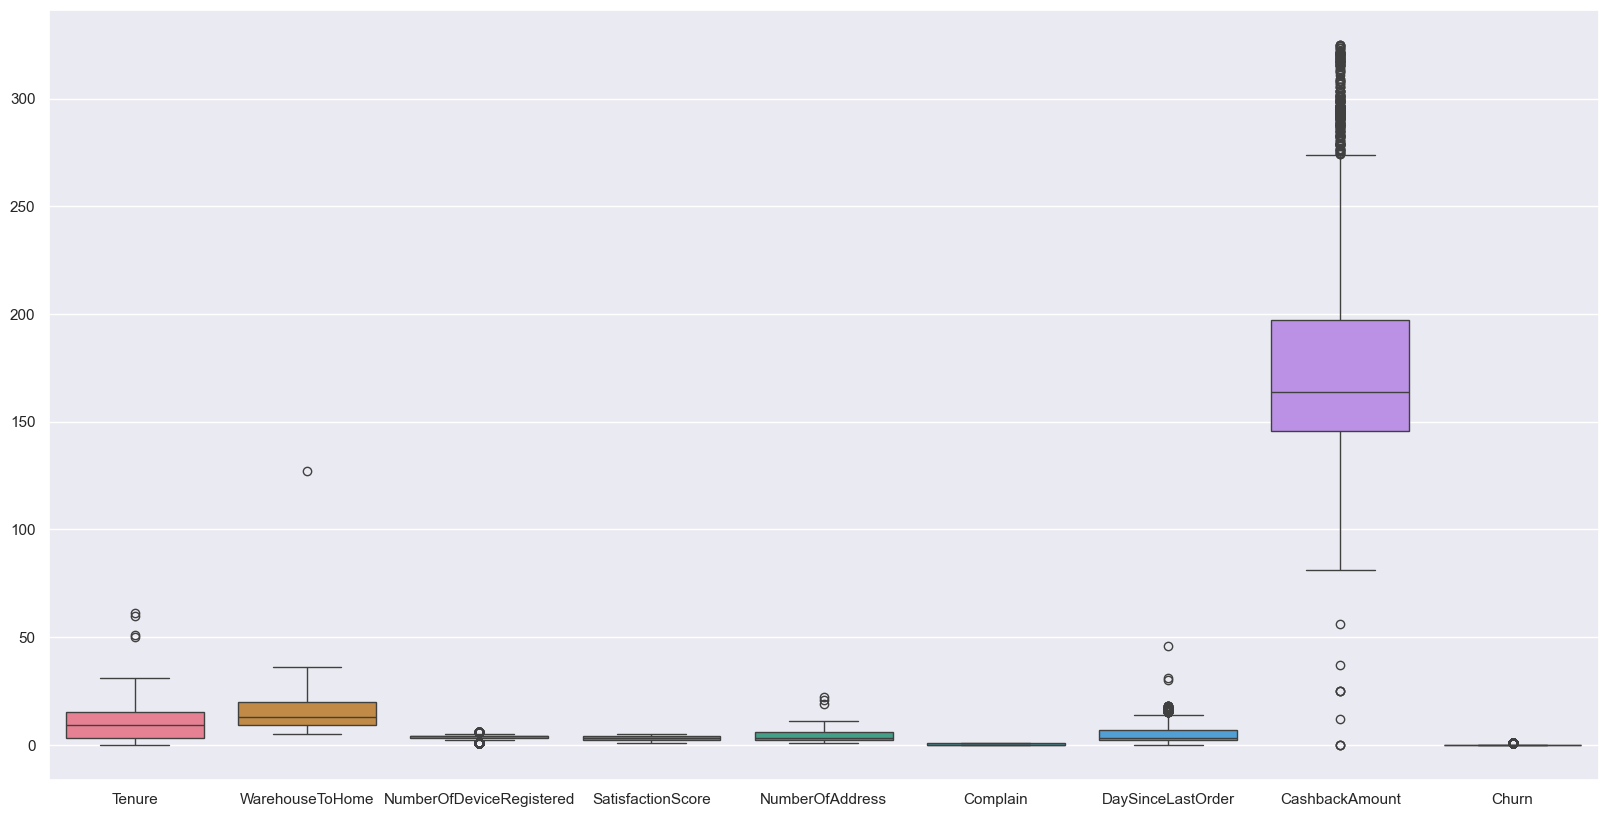

In [81]:
plt.figure(figsize=(20,10))
sns.boxplot(df.select_dtypes("number"))

outliers will be kept so that the model will be more resilient to anomalies

---

Data cleaning done :
- dropping duplicates (to prevent redundancy)
- filling null values with median (since the data numerical data is not normally distributed)
- keeping the outliers (so that the model will be more resilient to anomalies)

---

# 4. Feature selection

#### Selecting features using F test for continuous variables and Chi2 test for categorical variables
---

In [82]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

continuous_features = ["Tenure","WarehouseToHome","NumberOfDeviceRegistered","NumberOfAddress","DaySinceLastOrder","CashbackAmount"]
categorical_features = ["PreferedOrderCat","SatisfactionScore","MaritalStatus","Complain"]

# Apply ANOVA F-test to continuous features
continuous_selector = SelectKBest(score_func=f_classif, k='all')
continuous_selector.fit(df[continuous_features], df['Churn'])
continuous_scores = pd.DataFrame({
    'Feature': continuous_features,
    'Score': continuous_selector.scores_,
    'P-Value': continuous_selector.pvalues_
}).sort_values(by='Score', ascending=False)

# Apply chi-squared test to categorical features
encoded_df = pd.get_dummies(df[categorical_features])
chi2_selector = SelectKBest(score_func=chi2, k='all')
chi2_selector.fit(encoded_df, df['Churn'])
chi2_scores = pd.DataFrame({
    'Feature': encoded_df.columns,
    'Score': chi2_selector.scores_,
    'P-Value': chi2_selector.pvalues_
}).sort_values(by='Score', ascending=False)

# Combine scores for review
combined_scores = pd.concat([continuous_scores, chi2_scores], axis=0)

In [83]:
combined_scores

Feature       Score       P-Value
0                                Tenure  417.036852  2.442149e-87
5                        CashbackAmount   76.743644  3.068555e-18
4                     DaySinceLastOrder   68.399353  1.920073e-16
2              NumberOfDeviceRegistered   39.741666  3.287449e-10
1                       WarehouseToHome   14.102831  1.760993e-04
3                       NumberOfAddress    7.036933  8.023184e-03
1                              Complain  161.586993  5.092368e-37
10                 MaritalStatus_Single   67.460417  2.149597e-16
6         PreferedOrderCat_Mobile Phone   59.240689  1.395189e-14
5               PreferedOrderCat_Mobile   38.693004  4.959837e-10
4   PreferedOrderCat_Laptop & Accessory   37.738027  8.091179e-10
9                 MaritalStatus_Married   36.207010  1.774311e-09
3              PreferedOrderCat_Grocery   26.170606  3.125440e-07
0                     SatisfactionScore   20.390970  6.312696e-06
7               PreferedOrderCat_Others    8.730712  3.128943e-03
8                MaritalStatus_Divorced    0.325631  5.682430e-01
2              PreferedOrderCat_Fashion    0.246627  6.194605e-01

In [84]:
combined_scores["Feature"][combined_scores["P-Value"]<0.05].tolist()

['Tenure',
 'CashbackAmount',
 'DaySinceLastOrder',
 'NumberOfDeviceRegistered',
 'WarehouseToHome',
 'NumberOfAddress',
 'Complain',
 'MaritalStatus_Single',
 'PreferedOrderCat_Mobile Phone',
 'PreferedOrderCat_Mobile',
 'PreferedOrderCat_Laptop & Accessory',
 'MaritalStatus_Married',
 'PreferedOrderCat_Grocery',
 'SatisfactionScore',
 'PreferedOrderCat_Others']

In [85]:
insignificant = combined_scores["Feature"][combined_scores["P-Value"]>0.05].tolist()
insignificant

['MaritalStatus_Divorced', 'PreferedOrderCat_Fashion']

PreferedOrderCat_Fashion and MaritalStatus_Divorced will not be used in this model as they are not statistically significant to the target

# 5. Model Selection

## Splitting test size
---

In [86]:
X = df.drop(["Churn"],axis=1)
y = df["Churn"]

X_train_unprocessed,X_test_unprocessed,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

## Algorithm cross validation (scaling required)
---

In [87]:
transformer_with_scaler = ColumnTransformer([
    ("onehot",OneHotEncoder(drop="first"),["PreferedOrderCat","MaritalStatus"]),
    ("scaler",RobustScaler(),["Tenure","WarehouseToHome","NumberOfDeviceRegistered","NumberOfAddress","DaySinceLastOrder","CashbackAmount"])
    
],remainder="passthrough")

In [88]:
knn = KNeighborsClassifier()
logreg = LogisticRegression(random_state=42)

In [89]:
clf = [knn,logreg]
f2_mean = []
f2_std = []
f2_all = []
model_name=[]
f2_scorer = make_scorer(fbeta_score,beta=2,average="weighted")
#find the best model 
for i in clf:
    model_pipeline = Pipeline([
        ("transformer",transformer_with_scaler),
        ("modeling",i)
    ])
    model_cv = cross_val_score(
        model_pipeline,
        X_train_unprocessed,
        y_train,
        cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42),
        scoring=f2_scorer)
    
    f2_mean.append(model_cv.mean())
    f2_std.append(model_cv.std())
    f2_all.append(model_cv.round(4))
    model_name.append(i.__class__.__name__)

In [90]:
test = pd.DataFrame({
    "model":model_name,
    "train score":f2_mean,
    "std":f2_std,
    "all f2 value":f2_all
}).sort_values(by="train score",ascending=False)
test

model  train score       std  \
1    LogisticRegression     0.878507  0.008701   
0  KNeighborsClassifier     0.850005  0.013143   

                               all f2 value  
1   [0.8949, 0.8758, 0.8707, 0.8792, 0.872]  
0  [0.8614, 0.8383, 0.8504, 0.8673, 0.8327]

In [91]:
clf = [knn,logreg]

f2_score_list = []
model_name = []

for i in clf:
    model_pipeline = Pipeline([
        ("transformer",transformer_with_scaler),
        ("modeling",i)
    ])

    #fitting
    model_pipeline.fit(X_train_unprocessed,y_train)

    #model predict
    y_pred_test = model_pipeline.predict(X_test_unprocessed)

    #evaluate 
    f2 = fbeta_score(y_test,y_pred_test,beta=2,average="weighted")
    f2_score_list.append(f2)
    model_name.append(i.__class__.__name__)

In [92]:
score = pd.DataFrame({
    "model":model_name,
    "score":f2_score_list
}).sort_values(by="score",ascending=False)
score

model     score
1    LogisticRegression  0.887994
0  KNeighborsClassifier  0.864247

#### Final score for KNN and Logistic regression

---

In [93]:
result_non_trees = test.set_index("model").join(score.set_index("model"))
result_non_trees = result_non_trees.drop(["std","all f2 value"],axis=1)
result_non_trees["difference"] = result_non_trees["score"] - result_non_trees["train score"]
result_non_trees["difference"] = result_non_trees["difference"].agg("abs")
result_non_trees

train score     score  difference
model                                                  
LogisticRegression       0.878507  0.887994    0.009486
KNeighborsClassifier     0.850005  0.864247    0.014241

## Tree based algorithm cross validation (no scaling)
---

In [94]:
transformer = ColumnTransformer([
    ("onehot",OneHotEncoder(drop="first"),["PreferedOrderCat","MaritalStatus"])
    
],remainder="passthrough")

In [95]:
X_train_transformed = pd.DataFrame(transformer.fit_transform(X_train_unprocessed))
X_test_transformed = pd.DataFrame(transformer.transform(X_test_unprocessed))

In [96]:
tree = DecisionTreeClassifier(random_state=42)
forest = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
ada = AdaBoostClassifier(random_state=0)
gbc = GradientBoostingClassifier(random_state=0)

In [97]:
clf = [tree,forest,xgb,ada,gbc]
f2_mean = []
f2_std = []
f2_all = []
model_name=[]
f2_scorer = make_scorer(fbeta_score,beta=2,average="weighted")
#find the best model 
for i in clf:
    model_pipeline = Pipeline([
        ("transformer",transformer),
        ("modeling",i)
    ])
    model_cv = cross_val_score(
        model_pipeline,
        X_train_unprocessed,
        y_train,
        cv=StratifiedKFold(n_splits=5,shuffle=True,random_state=42),
        scoring=f2_scorer)
    
    f2_mean.append(model_cv.mean())
    f2_std.append(model_cv.std())
    f2_all.append(model_cv.round(4))
    model_name.append(i.__class__.__name__)

In [98]:
test = pd.DataFrame({
    "model":model_name,
    "train score":f2_mean,
    "std":f2_std,
    "all f2 value":f2_all
}).sort_values(by="train score",ascending=False)
test

model  train score       std  \
2               XGBClassifier     0.913795  0.013067   
4  GradientBoostingClassifier     0.900033  0.012582   
1      RandomForestClassifier     0.899991  0.007187   
3          AdaBoostClassifier     0.883366  0.012985   
0      DecisionTreeClassifier     0.875487  0.014901   

                               all f2 value  
2  [0.9135, 0.9131, 0.8932, 0.9345, 0.9147]  
4  [0.9092, 0.9123, 0.8789, 0.9073, 0.8925]  
1  [0.8995, 0.9075, 0.8866, 0.9042, 0.9021]  
3   [0.8937, 0.8947, 0.861, 0.8911, 0.8763]  
0  [0.8857, 0.8725, 0.8509, 0.8951, 0.8733]

In [99]:
#test score

clf = [tree,forest,xgb,ada,gbc]

f2_score_list = []
model_name = []

for i in clf:
    model_pipeline = Pipeline([
        ("transformer",transformer),
        ("modeling",i)
    ])

    #fitting
    model_pipeline.fit(X_train_unprocessed,y_train)

    #model predict
    y_pred_test = model_pipeline.predict(X_test_unprocessed)

    #evaluate 
    f2 = fbeta_score(y_test,y_pred_test,beta=2,average="weighted")
    f2_score_list.append(f2)
    model_name.append(i.__class__.__name__)

In [100]:
score = pd.DataFrame({
    "model":model_name,
    "test score":f2_score_list
}).sort_values(by="test score",ascending=False)
score

model  test score
2               XGBClassifier    0.923012
4  GradientBoostingClassifier    0.916514
1      RandomForestClassifier    0.914683
3          AdaBoostClassifier    0.905889
0      DecisionTreeClassifier    0.876738

#### Final scores for tree-based models 

---

In [101]:
result_trees = test.set_index("model").join(score.set_index("model"))
result_trees = result_trees.drop(["std","all f2 value"],axis=1)
result_trees["difference"] = result_trees["test score"] - result_trees["train score"]
result_trees["difference"] = result_trees["difference"].agg("abs")
result_trees

train score  test score  difference
model                                                          
XGBClassifier                  0.913795    0.923012    0.009217
GradientBoostingClassifier     0.900033    0.916514    0.016481
RandomForestClassifier         0.899991    0.914683    0.014691
AdaBoostClassifier             0.883366    0.905889    0.022523
DecisionTreeClassifier         0.875487    0.876738    0.001251

In [102]:
result_trees.to_csv("result trees.csv")
result_non_trees.to_csv("result non trees.csv")

### Summary : 

In [103]:
print("Tree algorithm results:\n",result_trees)
print("\n")
print("Non-tree algorithm results:\n",result_non_trees)

Tree algorithm results:
                             train score  test score  difference
model                                                          
XGBClassifier                  0.913795    0.923012    0.009217
GradientBoostingClassifier     0.900033    0.916514    0.016481
RandomForestClassifier         0.899991    0.914683    0.014691
AdaBoostClassifier             0.883366    0.905889    0.022523
DecisionTreeClassifier         0.875487    0.876738    0.001251


Non-tree algorithm results:
                       train score     score  difference
model                                                  
LogisticRegression       0.878507  0.887994    0.009486
KNeighborsClassifier     0.850005  0.864247    0.014241


XGB has the highest score and Decisiton tree has the most consistent score, therefore the model will be decided after hyperparameter tuning

# 6. Hyperparameter tuning

### XGboost
---

In [104]:
cat_features = ["PreferedOrderCat", "MaritalStatus"]

param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 4, 5, 6],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
    'model__gamma': [0, 0.1, 0.2]
}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

transformer = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first"), cat_features)
], remainder="passthrough")

# Initialize XGBClassifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Create the pipeline
estimator_XGB = Pipeline([
    ("estimator", transformer),
    ("model", xgb)
])

# Initialize GridSearchCV
tuned_model = GridSearchCV(
    estimator=estimator_XGB,
    param_grid=param_grid,
    cv=skfold,
    verbose=2,
    scoring=f2_scorer,
    n_jobs=-1
)

# Fitting the model
tuned_model.fit(X_train_unprocessed, y_train)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   0.0s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=1.0; total time=   0.0s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   0.0s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   0.0s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=50, model__subsample=0.8; total time=   0.0s
[CV] END model__colsample_bytree=0.8, model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('estimator',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['PreferedOrderCat',
                                                                          'MaritalStatus'])])),
                                       ('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_byn...
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__colsample_bytree': [0.8, 1.0],
                         'model__gamma': [0, 0.1, 0.2],
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5, 6],
                         'model__n_estimators': [50, 100, 200],
                         'model__subsample': [0.8, 1.0]},
             scoring=make_scorer(fbeta_score, beta=2, average=weighted),
             verbose=2)

In [105]:
#best score
print(f"best  in train set: {tuned_model.best_score_:.3f}")
#best param
print(f"best param in train set: {tuned_model.best_params_}")

best  in train set: 0.916
best param in train set: {'model__colsample_bytree': 1.0, 'model__gamma': 0, 'model__learning_rate': 0.2, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__subsample': 1.0}


In [106]:
best_model_xgb= tuned_model.best_estimator_

#fit 
best_model_xgb = best_model_xgb.fit(X_train_unprocessed,y_train)

#predict
y_pred_after_tuning_xgb = best_model_xgb.predict(X_test_unprocessed)

#evaluate
fbeta_score(y_test,y_pred_after_tuning_xgb,beta=2,average="weighted")

0.9311397819661684

In [107]:
model_pipeline_xgbc= Pipeline([
        ("transformer",transformer),
        ("model",xgb)])
#fitting
model_pipeline_xgbc.fit(X_train_unprocessed,y_train)

#model predict
y_pred_before_tuning_xgb = model_pipeline_xgbc.predict(X_test_unprocessed)

Text(0.5, 1.0, 'XGB after tuning')

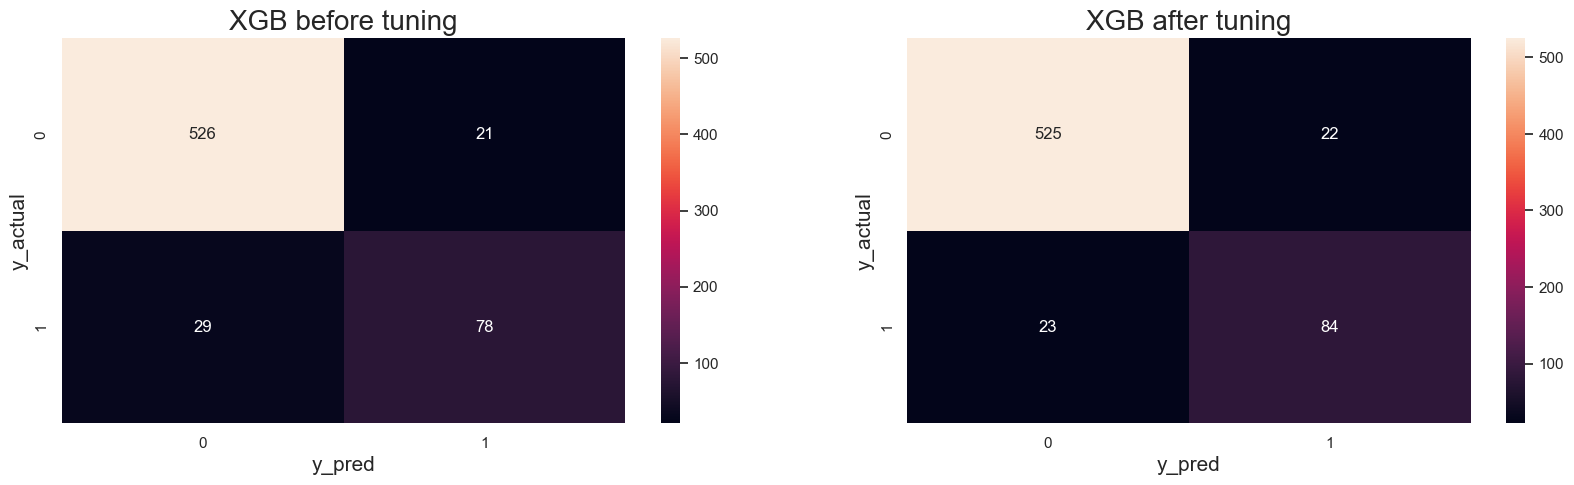

In [108]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test,y_pred_before_tuning_xgb),annot=True,fmt=".0f")
plt.xlabel("y_pred",fontsize=15)
plt.ylabel("y_actual",fontsize=15)
plt.title("XGB before tuning",fontsize=20)

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test,y_pred_after_tuning_xgb),annot=True,fmt=".0f")
plt.xlabel("y_pred",fontsize=15)
plt.ylabel("y_actual",fontsize=15)
plt.title("XGB after tuning",fontsize=20)

After tuning , the model succcessfully predicted 6 customers who were previously predicted to not churn but actually churn, and moved them to the true positive group . But 1 customer that was correctly predicted to no churn, moved to the false positive group. This is a good tradeoff since the positive class is more important, thus the tuning will be used.

### Result after tuning 

In [109]:
tuning_result = score[score["model"]=="XGBClassifier"].set_index("model").join(
    pd.DataFrame({"model":"XGBClassifier","test score after hyperparameter tuning":[0.9311397819661684]}).set_index("model"))
tuning_result

test score  test score after hyperparameter tuning
model                                                            
XGBClassifier    0.923012                                 0.93114

### Decision tree
---

In [110]:
cat_features = ["PreferedOrderCat", "MaritalStatus"]

param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [None, 10, 20, 30, 40, 50],
    'model__min_samples_split': [2, 10, 20],
    'model__min_samples_leaf': [1, 5, 10],
    'model__max_features': [None, 'auto', 'sqrt', 'log2'],
    'model__max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'model__min_impurity_decrease': [0.0, 0.01, 0.1]
}

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f2_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

transformer = ColumnTransformer([
    ("onehot", OneHotEncoder(drop="first"), cat_features)
], remainder="passthrough")

# Initialize XGBClassifier
tree = DecisionTreeClassifier(random_state=42)

# Create the pipeline
estimator_tree = Pipeline([
    ("estimator", transformer),
    ("model", tree)
])

# Initialize GridSearchCV
tuned_model_tree = GridSearchCV(
    estimator=estimator_tree,
    param_grid=param_grid,
    cv=skfold,
    verbose=False,
    scoring=f2_scorer,
    n_jobs=-1
)

# Fitting the model
tuned_model_tree.fit(X_train_unprocessed, y_train)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt

/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('estimator',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['PreferedOrderCat',
                                                                          'MaritalStatus'])])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [None, 10, 20, 30, 40, 50],
                         'model__max_features': [None, 'auto', 'sqrt', 'log2'],
                         'model__max_leaf_nodes': [None, 10, 20, 30, 40, 50],
                         'model__min_impurity_decrease': [0.0, 0.01, 0.1],
                         'model__min_samples_leaf': [1, 5, 10],
                         'model__min_samples_split': [2, 10, 20]},
             scoring=make_scorer(fbeta_score, beta=2, average=weighted),
             verbose=False)

In [111]:
best_model_dt= tuned_model_tree.best_estimator_

#fit 
best_model_dt = best_model_dt.fit(X_train_unprocessed,y_train)

#predict
y_pred_after_tuning_dt = best_model_dt.predict(X_test_unprocessed)

#evaluate
fbeta_score(y_test,y_pred_after_tuning_dt,beta=2,average="weighted")

0.8772917330830176

In [112]:
model_pipeline_tree= Pipeline([
        ("transformer",transformer),
        ("model",tree)])
#fitting
model_pipeline_tree.fit(X_train_unprocessed,y_train)

#model predict
y_pred_before_tuning_dt = model_pipeline_tree.predict(X_test_unprocessed)

Text(0.5, 1.0, 'DT after tuning')

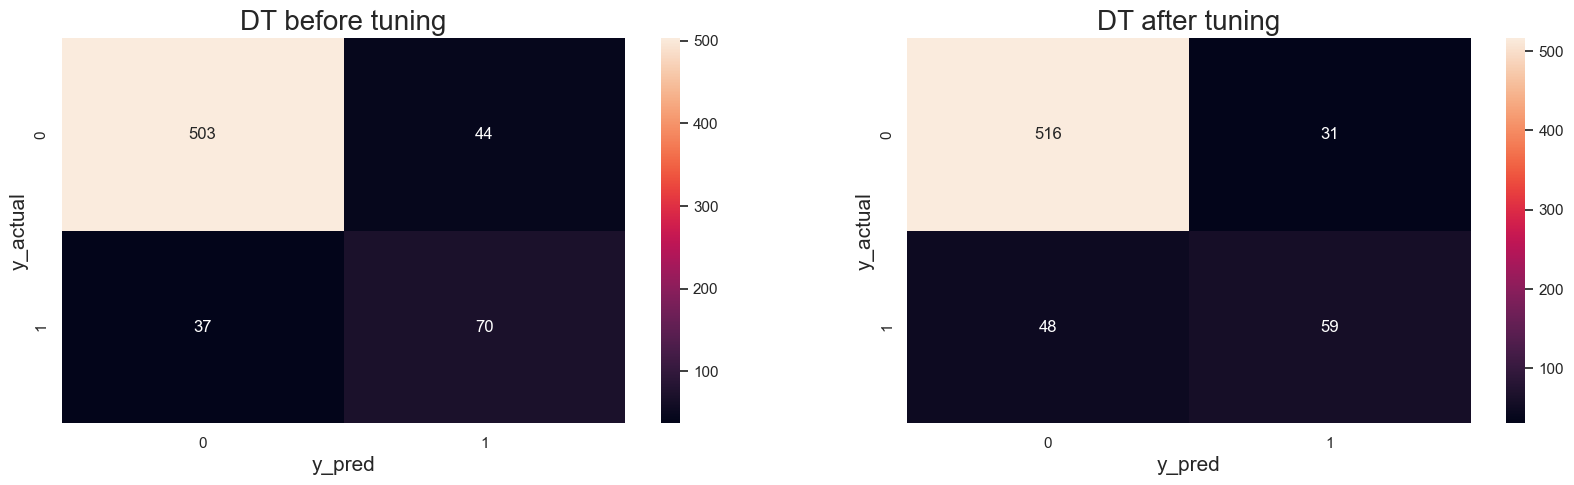

In [113]:
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test,y_pred_before_tuning_dt),annot=True,fmt=".0f")
plt.xlabel("y_pred",fontsize=15)
plt.ylabel("y_actual",fontsize=15)
plt.title("DT before tuning",fontsize=20)

plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test,y_pred_after_tuning_dt),annot=True,fmt=".0f")
plt.xlabel("y_pred",fontsize=15)
plt.ylabel("y_actual",fontsize=15)
plt.title("DT after tuning",fontsize=20)

The results for decision tree before tuning is better in catching the positive class compared to after tuning. Both results are inferior compared to XGBoost, therefore XGBoost will be the chosen model

---

# 7. Importance table

In [114]:
list1 = list(transformer.transformers_[0][1].get_feature_names_out())
features = list1 +['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder','CashbackAmount']
X_train_transformed.columns = features
X_test_transformed.columns = features

In [115]:
importance_table = pd.DataFrame(
    {'imp': best_model_xgb[1].feature_importances_, 'index': features}
).sort_values(by='imp', ascending=False)

print(importance_table)

         imp                                index
7   0.194637                               Tenure
12  0.137012                             Complain
0   0.091050             PreferedOrderCat_Grocery
1   0.083669  PreferedOrderCat_Laptop & Accessory
6   0.069905                 MaritalStatus_Single
11  0.061980                      NumberOfAddress
4   0.059627              PreferedOrderCat_Others
13  0.057306                    DaySinceLastOrder
10  0.045621                    SatisfactionScore
14  0.044647                       CashbackAmount
5   0.042241                MaritalStatus_Married
8   0.038665                      WarehouseToHome
9   0.035738             NumberOfDeviceRegistered
3   0.027222        PreferedOrderCat_Mobile Phone
2   0.010682              PreferedOrderCat_Mobile


<Axes: xlabel='imp', ylabel='index'>

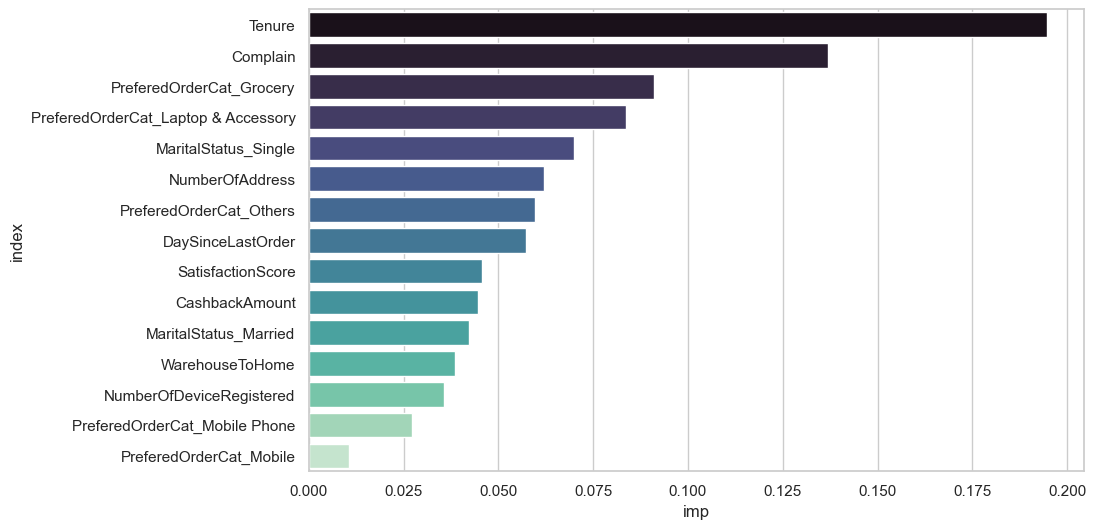

In [116]:
#visualization
plt.figure(figsize=(10,6))
sns.set_theme(style="whitegrid")
sns.barplot(data=importance_table,x="imp",y="index",orient="h",palette="mako")

We can see that Tenure is the most frequently used feature to make accurate predictions.

---

# 8. Partial Dependence

Partial dependence displays the interaction between the input features and the target (Churn)


<Figure size 2000x2000 with 0 Axes>

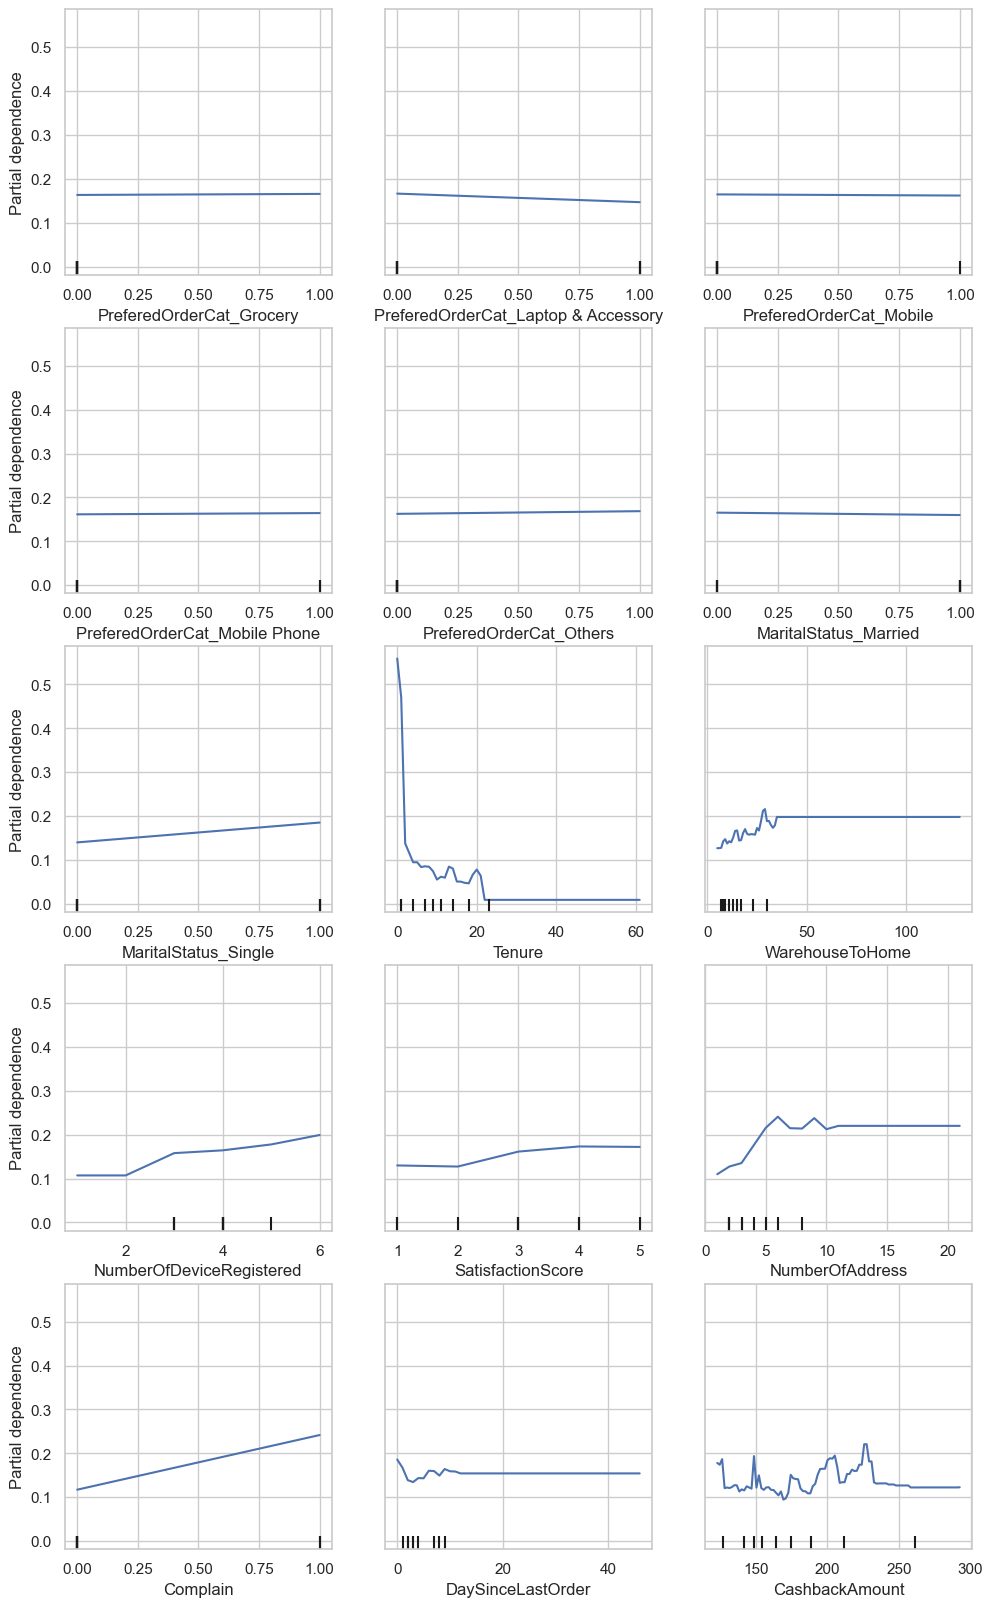

In [117]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,20
plt.figure(figsize=(20,20))
PD.from_estimator(best_model_xgb[1], X_train_transformed,features=features)

Important note :
* if the line is straight horizontal, that means the feature does not represent good contribution to the change of customer churn probability

Notable examples :
* Complain : customers who complained will be more likely to churn compared to those who did not complain
* Tenure : low tenure increases the probabilty of churn. The higher the tenure, the probability of churn decreases. The probability stops deceasing at around tenure=22
* Cashback : cashback displays fluctuative line, which indicates that this feature does not represent good contribution to the change of customer churn probability
---

# 9. SHAP analysis

In [118]:
# Convert the model to a SHAP explainer
explainer = shap.TreeExplainer(best_model_xgb[1])

# Calculate SHAP values for the test set
shap_values = explainer(X_test_transformed)

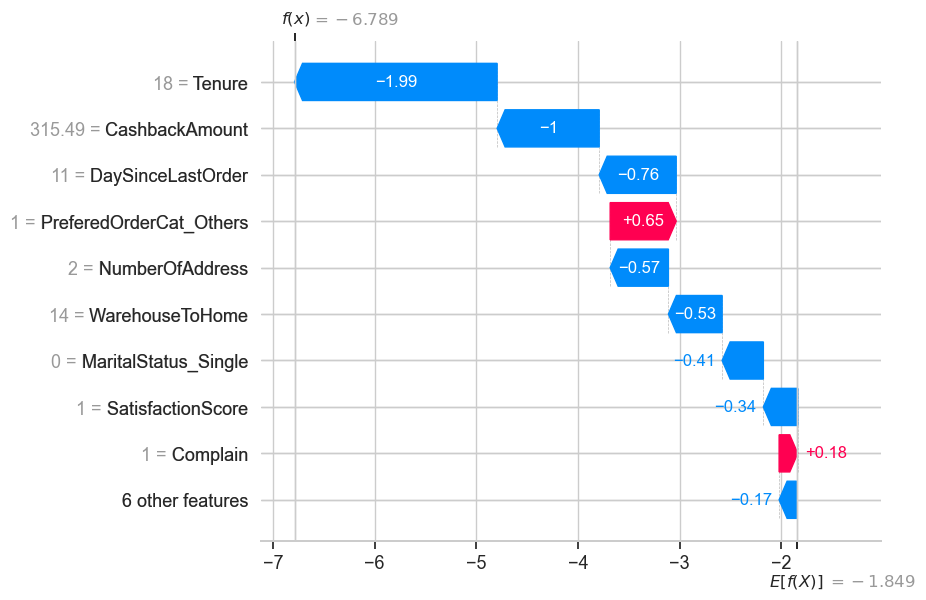

In [119]:
# plotting for each customer
shap.plots.waterfall(shap_values[0])

#### The waterfall plot above indicates the additive contribution for the model's inclination to predict 0 or not churn based on the customers data #1
---

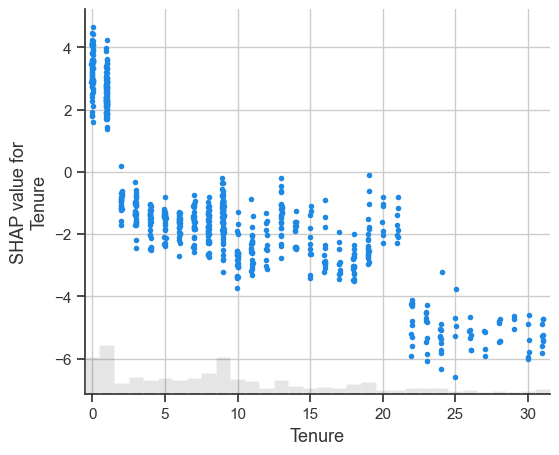

In [120]:
shap.plots.scatter(shap_values[:,"Tenure"])

#### The shap scatter plot above indicates how Tenure affects the model's prediction. It explains the higher the tenure, the model will be more likely to predict 0 or not churn
---

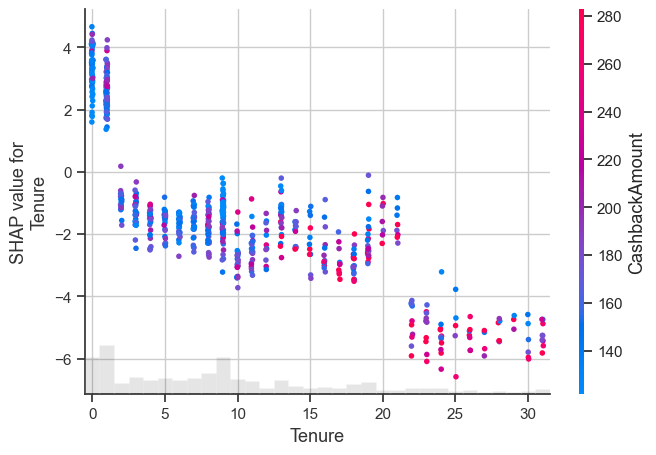

In [121]:
shap.plots.scatter(shap_values[:,"Tenure"], color=shap_values[:,"CashbackAmount"])

#### The scatter plot above explains how the vertical distribution of customers' tenure can also explain the customers' cashback amount. It says that customers with high tenure also receive higher cashback amount (indicated by red colors)
---

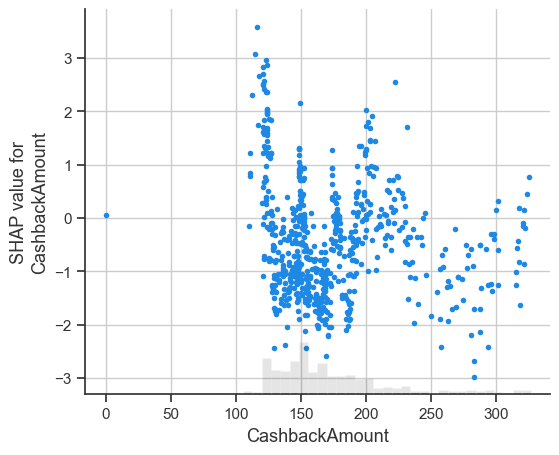

In [122]:
shap.plots.scatter(shap_values[:,"CashbackAmount"])

#### cashback amount is not a good indication on how the model makes decision since it looks randomly distributed. This might indicate that cashback does not have a clear impact on churn
---

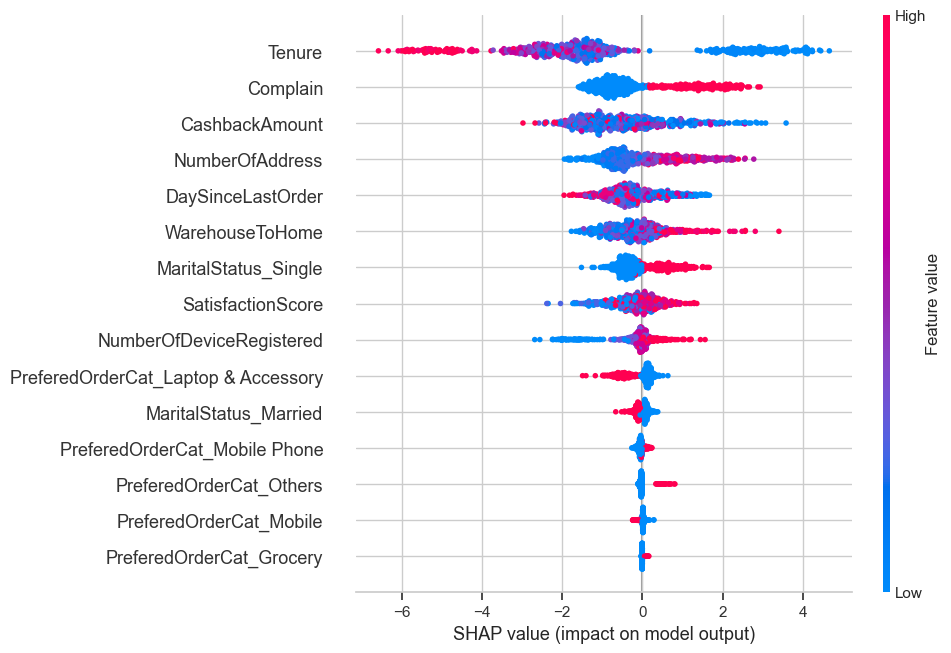

In [123]:
shap.plots.beeswarm(shap_values,max_display=20)

#### The beeswarm plot above indicates the distribution of all customers and how they affect the model's descision making. 

example :
- low tenure impacts the model positively while low tenure impacts the model negatively. This indicates that the e-commerce needs to give attention to customers with low tenure to avoid churn
- people who complained impacts the model positively while people who did not complain impacts the model negatively. This indicates that if the e-commerce pays attention to the complains and handle them correctly, it might help avoid customer churn
---

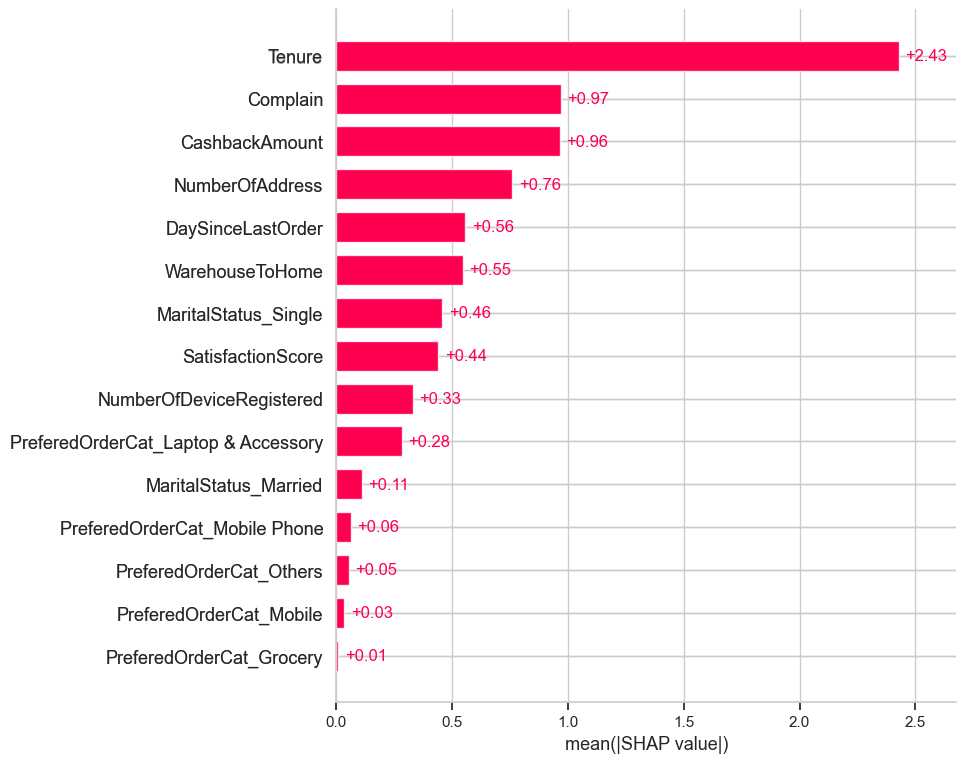

In [124]:
shap.plots.bar(shap_values,max_display=20)

The bar chart above indicates the average impact of the feature on the model's output. Higher values mean the feature has a higher average impact.

# 10. LIME Analysis

In [125]:
import lime
from lime import lime_tabular

In [126]:
explainer = lime_tabular.LimeTabularExplainer(training_data=best_model_xgb[0].transform(X_train_unprocessed),
                                              feature_names = features,
                                              discretize_continuous= True,
                                              class_names = ["Not Churn","Churn"],
                                              mode="classification",
                                              discretizer="decile")

explainer

The prediction of this customer is :does not churn--> from y_test


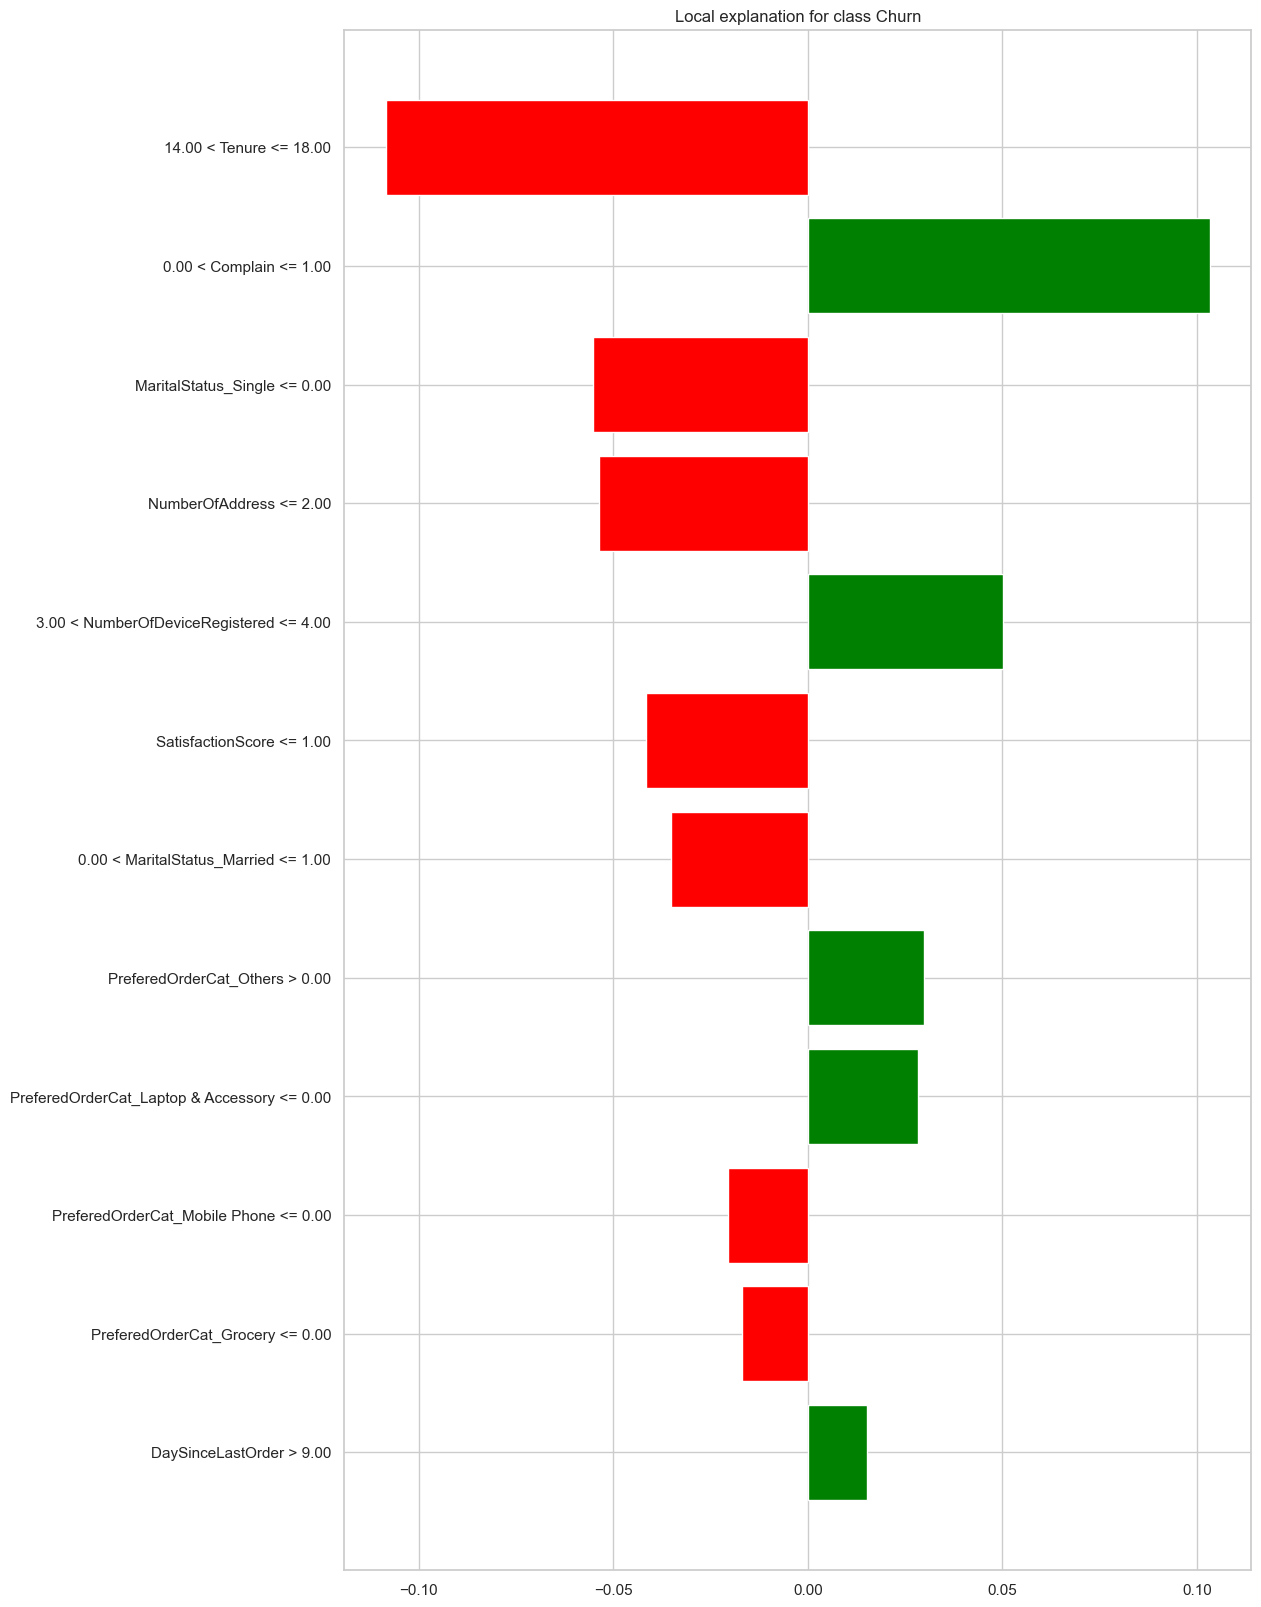

In [127]:
i = 0
print(f"The prediction of this customer is :{('Churn' if y_test.iloc[i] == 1 else 'does not churn')}--> from y_test")

exp = explainer.explain_instance(X_test_transformed.iloc[i],
                                 best_model_xgb["model"].predict_proba,
                                 num_features=12)

exp.as_pyplot_figure()
plt.show()

LIME bar above indicates that Complain and Tenure had the most magnitude on impacting the model's prediction for the customer #1 

---

In [128]:
i=0
print(f"The prediction of this customer is :{('Churn' if y_test.iloc[i] == 1 else 'does not churn')}--> from y_test")

exp = explainer.explain_instance(X_test_transformed.iloc[i],
                                 best_model_xgb["model"].predict_proba,
                                 num_features=15)

exp.show_in_notebook(show_table=True)

The prediction of this customer is :does not churn--> from y_test


LIME table above indicates that the detailed characteristics ,how they affect the model's prediction and the prediction probabilities for the customer #1 

---

# 11. Checking number of correct predictions in test set

In [129]:
check_result = pd.DataFrame({
    "prediction":y_pred_after_tuning_xgb.tolist(),
    "result":y_test
})

def conclusion(row):
    if row["prediction"]==row["result"]:
        return "Correct"
    else:
        return "False"
check_result["conclusion"] = check_result.apply(conclusion,axis=1)
print(check_result)
print(check_result["conclusion"].value_counts())
print(confusion_matrix(y_test,y_pred_after_tuning_xgb))
print(classification_report(y_test,y_pred_after_tuning_xgb))

      prediction  result conclusion
1028           0       0    Correct
3666           0       0    Correct
626            0       0    Correct
229            0       0    Correct
2207           1       1    Correct
...          ...     ...        ...
804            0       0    Correct
2432           0       0    Correct
1967           0       0    Correct
587            0       0    Correct
2242           0       0    Correct

[654 rows x 3 columns]
conclusion
Correct    609
False       45
Name: count, dtype: int64
[[525  22]
 [ 23  84]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       547
           1       0.79      0.79      0.79       107

    accuracy                           0.93       654
   macro avg       0.88      0.87      0.87       654
weighted avg       0.93      0.93      0.93       654



---

In [130]:
amount_saved = check_result[((check_result["prediction"]==1) & (check_result["result"]==0))|((check_result["prediction"]==1) & (check_result["result"]==1))]
print("amount of actual money saved :" ,df["CashbackAmount"].loc[amount_saved.index].sum())

amount of actual money saved : 16461.69


From the result of confusion matrix in the test set, we can see that the model successfully predicted :
- 525 True Negatives = The customers who were predicted to not churn and actually not churn
- 23 False Negatives (type II error) = The customers who were predicted to not churn but actually churn
- 22 False Positives (type I error) = The customers who were predicted to churn but actually not churn
- 84 True Positives = The customers who were predicted to churn and actually churn


Cashback will not be given the False Positive group and True Positive group, since they are predicted to churn regardless they will churn or not. 

The amount saved from cashback is totalling to 16461.69 Dollars

---

### Here are the data set that the model failed to predict

In [131]:
#incorrect predictions
incorrect_predictions = check_result[check_result["conclusion"]=="False"].index
df.loc[incorrect_predictions]

Tenure  WarehouseToHome  NumberOfDeviceRegistered    PreferedOrderCat  \
2696     7.0             16.0                         3              Mobile   
3183     1.0              9.0                         4        Mobile Phone   
534      0.0             16.0                         4             Fashion   
2120     0.0              9.0                         4              Mobile   
2824     1.0             23.0                         2        Mobile Phone   
270      0.0              9.0                         4             Fashion   
102     19.0             13.0                         3              Mobile   
901      3.0              9.0                         5        Mobile Phone   
2566     2.0              8.0                         4        Mobile Phone   
2018     0.0             21.0                         3              Mobile   
2898     1.0             29.0                         5        Mobile Phone   
1789     0.0             13.0                         3              Mobile   
3302     8.0             29.0                         3        Mobile Phone   
410      9.0             16.0                         3             Fashion   
636      0.0             23.0                         4  Laptop & Accessory   
469      8.0             17.0                         4        Mobile Phone   
1062     0.0              8.0                         1              Mobile   
2716    10.0             17.0                         4             Fashion   
3138     4.0             26.0                         3              Mobile   
1686     6.0             13.0                         3              Mobile   
350      9.0             31.0                         5              Mobile   
2804     5.0             12.0                         5        Mobile Phone   
2969     0.0             22.0                         1              Mobile   
3112     1.0             31.0                         4        Mobile Phone   
2449     0.0             11.0                         4              Mobile   
2942     1.0             24.0                         4        Mobile Phone   
2939     3.0             28.0                         4  Laptop & Accessory   
515      1.0             30.0                         5             Fashion   
1229     9.0              8.0                         4              Mobile   
609     13.0             15.0                         3        Mobile Phone   
431      1.0             19.0                         5        Mobile Phone   
789      0.0             10.0                         3              Mobile   
126      1.0              9.0                         4        Mobile Phone   
708      9.0              6.0                         3              Mobile   
1249     0.0             13.0                         3              Mobile   
1850     1.0             32.0                         4        Mobile Phone   
3028     1.0             10.0                         4  Laptop & Accessory   
2600     0.0             13.0                         3              Mobile   
923      9.0              9.0                         3        Mobile Phone   
455      0.0             11.0                         3        Mobile Phone   
3287     0.0             30.0                         3        Mobile Phone   
379      4.0             14.0                         4        Mobile Phone   
2093     0.0             11.0                         3        Mobile Phone   
2112     1.0              9.0                         4        Mobile Phone   
966      1.0             12.0                         4        Mobile Phone   

      SatisfactionScore MaritalStatus  NumberOfAddress  Complain  \
2696                  3        Single                2         1   
3183                  3       Married                8         1   
534                   5       Married               10         0   
2120                  1       Married                1         1   
2824                  1       M

# 12. Export model

In [132]:
import pickle

model_final = best_model_xgb

pickle.dump(model_final,open("Capstone : XGB model.sav","wb"))